__Name: Samuel Olusegun \.
CHE5382 HW 4__

__The reduced pressure used is 1.011. The pressure value is taken from the paper below__

_J. Karl Johnson , John A. Zollweg & Keith E. Gubbins (1993) The Lennard-Jones equation of state revisited, Molecular Physics, 78:3, 591-618, DOI: 10.1080/00268979300100411_

In [11]:
#import the rquired libraries
import numpy as np
import matplotlib.pyplot as plt

In [25]:
#define the given conditions (box length, density, number of shells, number of particles, maximum distance)
box_L = 18
rho = 0.75
num_shells = box_L*5
num_part = int(rho*box_L**3)
max_dist = box_L/2
#r = np.linspace(0.01,3.0,num=600)
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
Rcutoff = 2.5 #cutoff for truncation
T0=1.0

In [26]:
box_length = box_L  # Length of the cubic cell
density = rho

# Calculate the number of particles
volume = box_length**3
num_particles = int(density * volume)

# Generate positions for a simple cubic lattice
# Assuming particles are evenly spaced along each axis
#n_side = int(np.cbrt(num_particles))  # Number of particles along one side
#spacing = box_length / n_side  # Spacing between particles
n_side = box_L-1
spacing = box_L/n_side
# Generate particle positions for the lattice
particle_positions = []
for x in range(n_side):
    for y in range(n_side):
        for z in range(n_side):
            if len(particle_positions)< num_particles:
                particle_positions.append([x * spacing + spacing/2, 
                                           y * spacing + spacing/2, z * spacing+ spacing/2])
particle_positions = np.array(particle_positions)- box_L/2
print('The total number of particles is: ',len(particle_positions))
tri_up=np.transpose(np.tri(len(particle_positions), dtype=int, k=-1))
zero_diag= np.ones((num_part,num_part), dtype=int) 
zero_diag[np.diag_indices(num_part)] = 0 

The total number of particles is:  4374


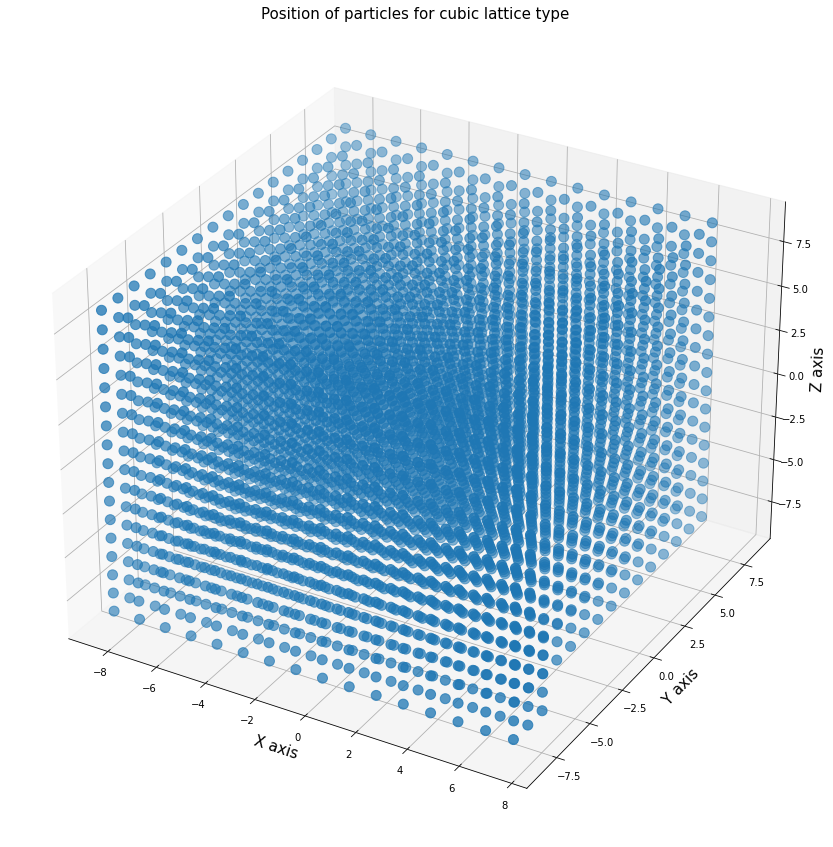

In [4]:
#plot the generated particle positions
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(particle_positions[:,0],particle_positions[:,1],particle_positions[:,2], marker='o',s=100)
ax.set_xlabel('X axis', fontsize=15)
ax.set_ylabel('Y axis', fontsize=15)
ax.set_zlabel('Z axis', fontsize=15)
plt.title('Position of particles for cubic lattice type', fontsize=15)
plt.show()

In [27]:
#function to calculate the RDF for an ideal gas with the given conditions
def ideal_rdf(num_shells, rho, r, num_part):
    Id_rdf = np.zeros(num_shells)
    ri_list = np.zeros(num_shells)
    dr = r/num_shells                                 #thickness of shell
    for i in range(len(Id_rdf)):
        ri=i/(num_shells/max_dist) + 0.5*dr           #radius r is at the center of each shell
        Id_rdf[i]=4*np.pi*(ri**2)*dr*rho * num_part   #g(r)_ideal = V *N/V * 4*pi*r^2*dr*rho
        ri_list[i]=ri
    return ri_list,Id_rdf

In [28]:
#function to calculate the RDF of a randomly distributed particle
def calc_rdf(num_shells, r, co_od, num_part):
    Id_rdf = np.zeros(num_shells)
    for i in range(num_part):             # calculate n(n-1)/2 distances
        for j in range(i + 1, num_part):
            posi = co_od[i]
            posj = co_od[j]
            RIJ = posi -posj
            # calculate the minimum image distance assumming periodic boundary condition
            min_RIJ = RIJ - box_L*np.floor(RIJ/box_L+0.5)   
            min_RIJ2 = min_RIJ * min_RIJ
            dr = np.sqrt( min_RIJ2.sum() ) # calculate the distances
            if dr < r:      #if the distance is within the needed range (half the box length), add to g(r)
                shell = int(dr * (num_shells/max_dist))  
                Id_rdf[shell] += 2    #count in pairs
    return Id_rdf

In [29]:
#function to calculate the RDF/RDF_ideal
def get_g(num_part,num_shells, r, co_od,rho):
    dr,Id_rdf = ideal_rdf(num_shells,rho,box_L/2, num_part)  
    cal_rdf = calc_rdf(num_shells,box_L/2,co_od,num_part)
    g = np.zeros(num_shells)
    for i in range(len(g)):
        g[i]=cal_rdf[i]/(Id_rdf[i])     #g(r) = N(r)/N(r)_ideal
    init = np.zeros(1)
    ri = np.concatenate((init,dr))   #Use (0,0) as the starting point
    g_r = np.concatenate((init,g))
    return ri,g_r,dr,Id_rdf,cal_rdf

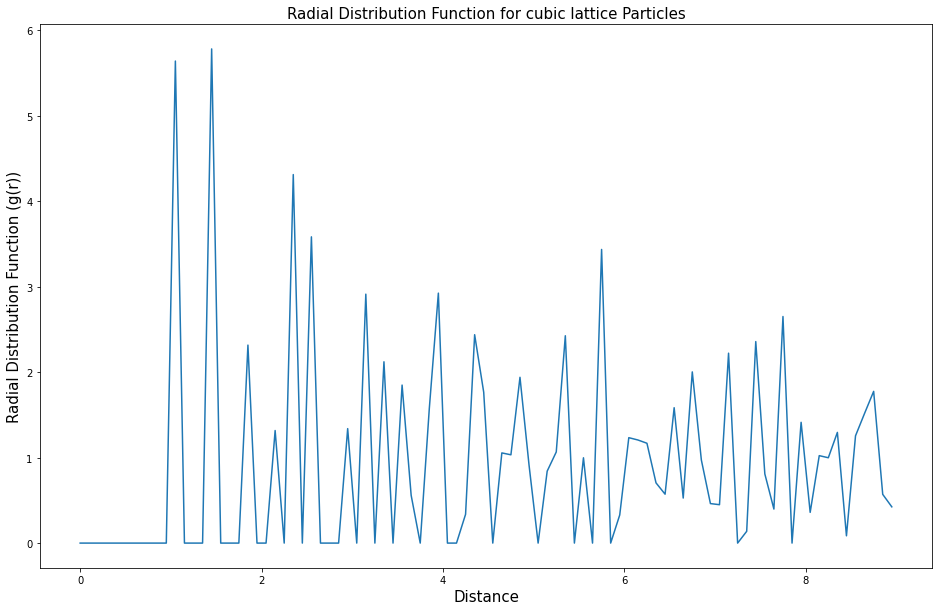

In [8]:
#Ploting the RDF for the initial lattice configuration
num_shells=box_L*5
r=box_L/2
co_od = np.array(particle_positions)
ri,g_r,dr,Id_rdf,cal_rdf = get_g(num_part,num_shells, r, co_od,rho)
plt.figure(figsize=(16,10))
plt.plot(ri, g_r)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Radial Distribution Function (g(r))', fontsize=15)
plt.title('Radial Distribution Function for cubic lattice Particles', fontsize=15)
plt.show()

In [30]:
#function to return minimum distances(rij) and minimum displacement on each axis(xij,yij,zij)
def distance_matrix(particle_positions,box_L):
    a=np.resize(particle_positions,[num_part,num_part,3])
    aT=np.transpose(a,(1,0,2))
    d=aT-a
    min_d=(d - box_L*np.floor(d/box_L+0.5))
    r=np.sqrt(np.sum(np.square(min_d),axis=2))
    return r

In [31]:
def new_distance_matrix(particle_positions,box_L,E_to, atom_n, change):
    a=np.stack([particle_positions[atom_n]] * num_part)
    a1=np.stack([particle_positions[atom_n]+change] * num_part)
    aT=particle_positions.copy()
    d=a-aT
    d1=a1-aT
    min_d=(d - box_L*np.floor(d/box_L+0.5))
    min_d1=(d1 - box_L*np.floor(d1/box_L+0.5))
    r=np.sqrt(np.sum(np.square(min_d),axis=1))
    r1=np.sqrt(np.sum(np.square(min_d1),axis=1))
    rt=np.array([r,r1])
    return rt

In [32]:
#Verlet Neighbor list function (for bonus point)
def verlet_neighbor(eu_dis1,rad):
    Vn_list=np.where(eu_dis1 > rad, 0, 1)
    Vn_list[np.diag_indices(num_part)] = 0
    return Vn_list

In [33]:
#Verlet Neighbor list function (for bonus point)
def new_verlet_neighbor(eu_dis1,rad,atom_n):
    Vn_list=np.where(eu_dis1 > rad, 0, 1)
    Vn_list[:,atom_n]=0
    return Vn_list

In [34]:
#function to return Potential enery(PE) and Forces (summation and piecewise) 
def E_F(particle_positions,box_L):
    eu_dist=distance_matrix(particle_positions,box_L)
    cut= verlet_neighbor(eu_dist,Rcutoff)
    mat=tri_up*cut
    eu_dist[eu_dist == 0] = 1
    E_L= np.sum((4*((mat/eu_dist)**12-(mat/eu_dist)**6)-(mat*E_shift)))
    return E_L

In [35]:
#function to return Potential enery(PE) and Forces (summation and piecewise) 
def new_E_F(particle_positions,box_L,E_to, atom_n, change):
    r=new_distance_matrix(particle_positions,box_L,E_to, atom_n, change)
    cut = new_verlet_neighbor(r,2.5,atom_n)
    r[r == 0] = 1
    Ec= np.sum((4*((cut/r)**12-(cut/r)**6)-(cut*E_shift)) ,axis=1)
    E_L = E_to-Ec[0]+Ec[1]
    ppp= particle_positions.copy()
    ppp[atom_n]=ppp[atom_n]+change
    newp=(ppp - box_L*np.floor(ppp/box_L+0.5))
    return E_L,newp,Ec[0],Ec[1]

#Note that all repeated function with prefix new_ is used to calculate system energy change after a MC move.

In [36]:
#eu_dis,min_d=distance_matrix(particle_positions,box_L)
E_shift=(4.0/(Rcutoff**12)-4.0/(Rcutoff**6))

In [16]:
#The initial Potential Energy of the system
E_F(particle_positions,box_L)

-20104.169911767152

In [37]:
#function to save result of simulation and function to read saved data
def savedat(xx,yy):
    import pickle

    pickle.dump([xx,yy], open("filename22", "wb"))

    return
def read_file(filename):
    import pickle
    c,d = pickle.load(open(filename,"rb"))
    return c,d

In [38]:
def Monte_carlo(pps):
    pp=pps.copy()
    boxL=box_L
    P=1.011
    Ei=E_F(pp,boxL)
    E_list = []
    perc_list = []
    accept_list = []
    dens_list = []
    p_list =[]
    Eo=0
    accept = 0
    vaccept = 0
    trials = 0
    vtrials=0
    vtrial=0.0001
    rnd=0
    apd = 0
    posi =0
    while accept<500000:
        delta = np.random.uniform(low=-0.08, high=0.08, size=3)
        atom = int(np.random.uniform(low=0, high=num_part-1, size=1)+0.5)
        E,p,E0,E1 = new_E_F(pp,boxL,Ei, atom, delta)
        #E2 = E_F(p,boxL)
        #print(E,E2)
        prob = np.random.uniform(low=0, high=1.0, size=1)
        trials += 1

        if accept-vtrials>1000:
            vtrial+=1
            Vdelta = np.random.uniform(low=0.99, high=1.01, size=1)
            V=boxL**3
            Vnew = V*Vdelta
            delV=Vnew-V
            #ppV=pp*(1+0.5*(1-Vdelta**(1/3)))
            ppV=pp*(Vdelta**(1/3))
            boxV=boxL*(Vdelta**(1/3))
            Edi= E_F(pp,boxL)
            EdV=E_F(ppV,boxV)
            #print(Edi,EdV,boxV,P*delV,num_part*np.log(Vdelta))
            HdV = EdV - Edi + P*delV + num_part*np.log(Vdelta)
            #HdV = EdV - Edi + P*delV
            #print('the helmholtz is ', HdV)
            prob1 = np.random.uniform(low=0, high=1.0, size=1)
            if HdV<=0:
                pp=ppV.copy()
                Ei=EdV.copy()
                boxL=boxV.copy()
                vaccept +=1
            else:
                boltzv = np.exp(-(HdV))
                if prob1 < boltzv:
                    pp=ppV.copy()
                    Ei=EdV.copy()
                    boxL=boxV.copy()
                    vaccept += 1
            vtrials+=1000
        
        
        if E1<E0:
            pp=p.copy()
            Eo=Ei.copy()
            Ei=E.copy()
            accept += 1
    
        else:
            boltz = np.exp(-(E1-E0))
            if prob < boltz:
                pp=p.copy()
                Eo=Ei.copy()
                Ei=E.copy()
                accept += 1


        dens = num_part/(boxL**3)    
        perc = accept/trials * 100
        percv = vaccept/vtrial *100
        #print(Ei,Eo,perc,trials,accept)
        print(Ei,Eo,perc,percv,trials,accept,dens,boxL)
        if accept-apd>10:
            E_list.append([Ei,perc,accept,trials,dens])
            apd+=10
        if accept-posi>400:
            p_list.append(pp)
            posi+=400
        #plt.plot(accept_list,E_list)
        #plt.plot(accept_list,perc_list)
        #plt.show()
    E_list=np.array(E_list)
    p_list = np.array(p_list)
    savedat(E_list,p_list)
    return E_list,p_list

In [63]:
#run MD simulation and estimate total time
import time
start_time = time.time()
a,b=Monte_carlo(particle_positions)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:",execution_time)

In [47]:
data,q=read_file(filename="./Downloads/NPT/filename22")

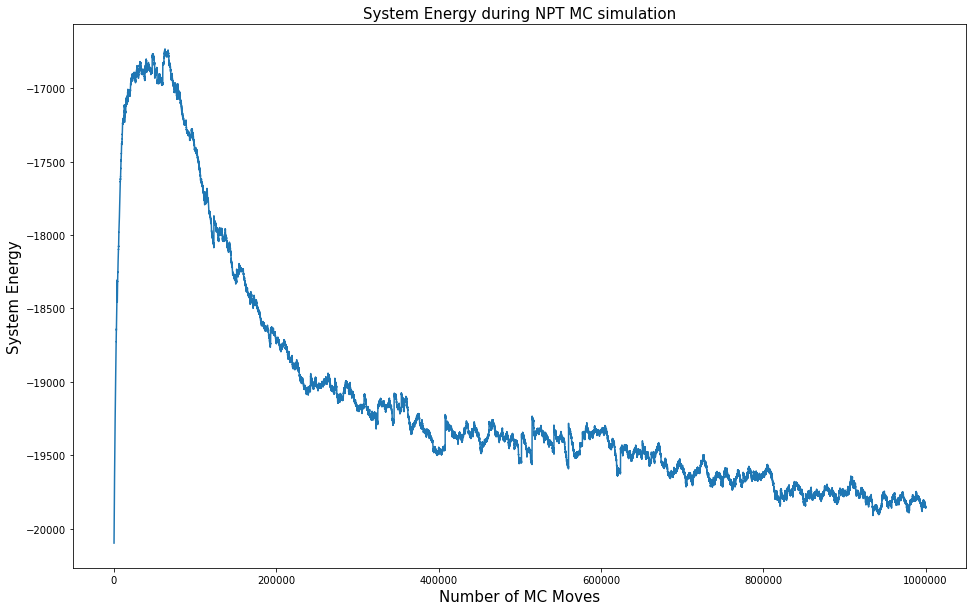

In [57]:
plt.figure(figsize=(16,10))
plt.plot(data[:,2],data[:,0])
plt.xlabel('Number of MC Moves', fontsize=15)
plt.ylabel('System Energy', fontsize=15)
plt.title('System Energy during NPT MC simulation', fontsize=15)
#plt.xlim((-1, 1000000))
plt.ticklabel_format(style='plain')
plt.show()

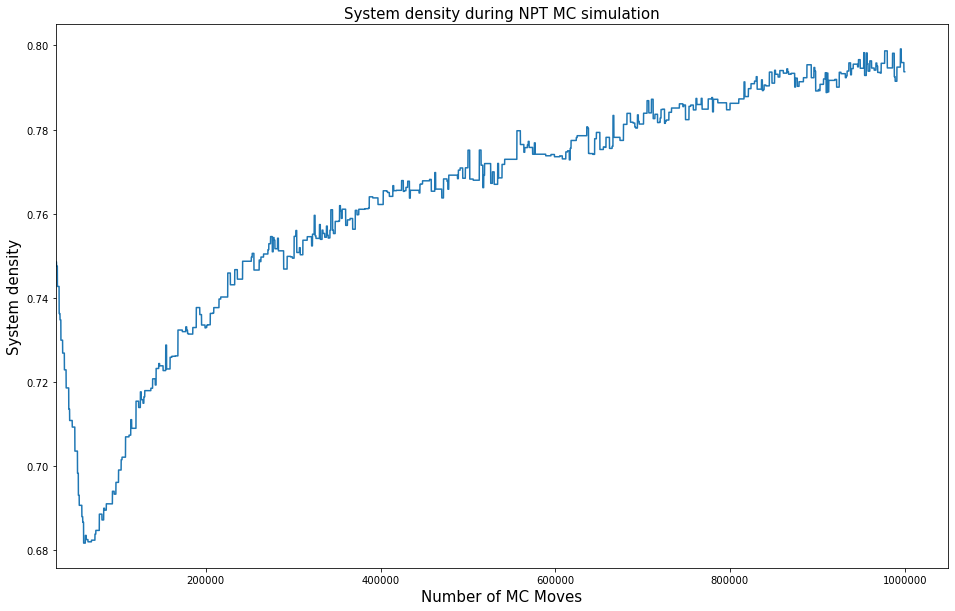

In [72]:
plt.figure(figsize=(16,10))
plt.plot(data[:,2],data[:,4])
plt.xlabel('Number of MC Moves', fontsize=15)
plt.ylabel('System density', fontsize=15)
plt.title('System density during NPT MC simulation', fontsize=15)
plt.ticklabel_format(style='plain')
plt.show()

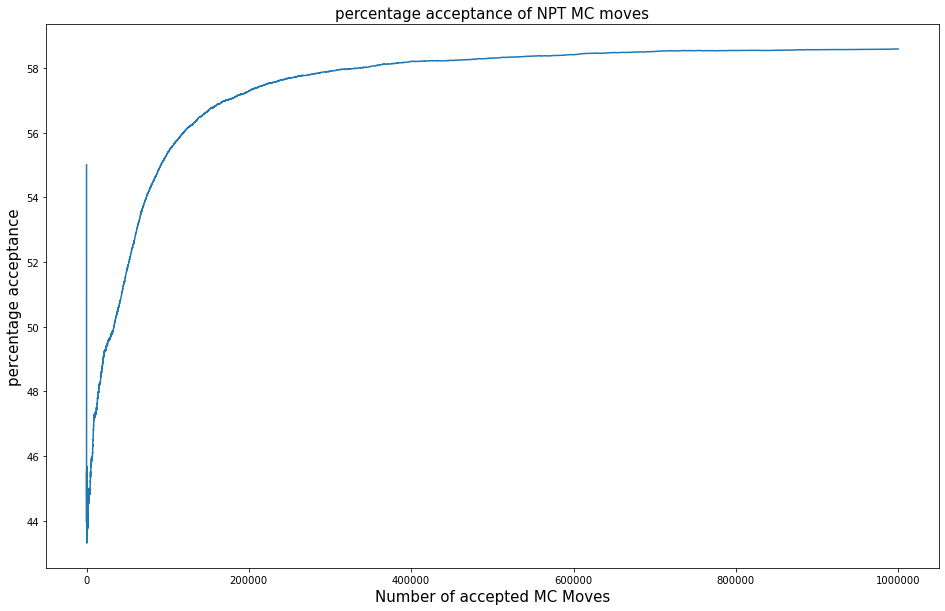

In [59]:
plt.figure(figsize=(16,10))
plt.plot(data[:,2],data[:,1])
plt.xlabel('Number of accepted MC Moves', fontsize=15)
plt.ylabel('percentage acceptance', fontsize=15)
plt.title('percentage acceptance of NPT MC moves', fontsize=15)
#plt.ylim((0.5, 1.4))
plt.ticklabel_format(style='plain')
plt.show()

In [54]:
#average configuration of equilibrated system
avg_position = np.average(np.array(q[-10:-1]),axis=0)

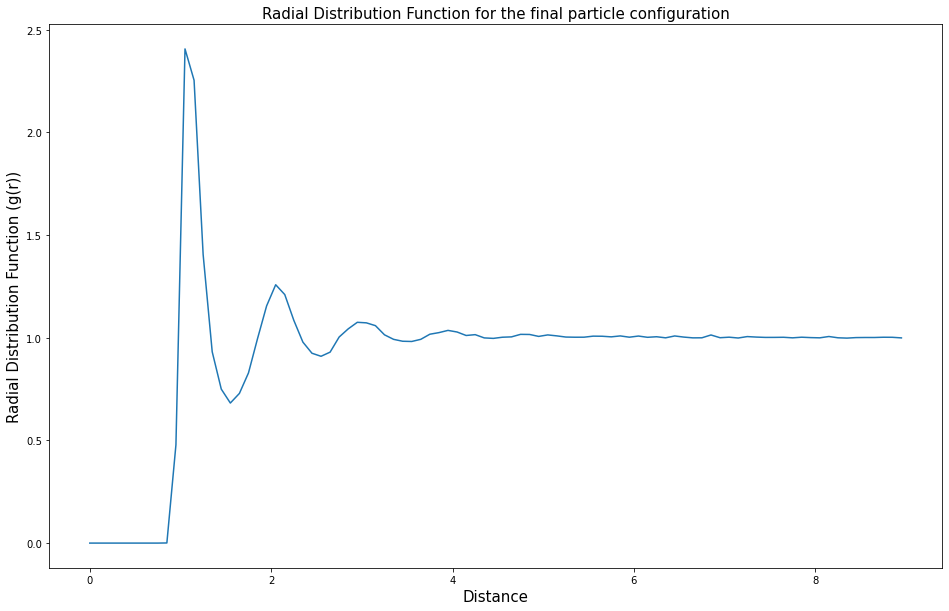

In [55]:
#Ploting the RDF for the final particle configuration
num_shells=box_L*5
r=box_L/2
co_od = q[-1]
ri,g_r,dr,Id_rdf,cal_rdf = get_g(num_part,num_shells, r, co_od,rho)
plt.figure(figsize=(16,10))
plt.plot(ri, g_r)
plt.xlabel('Distance', fontsize=15)
plt.ylabel('Radial Distribution Function (g(r))', fontsize=15)
plt.title('Radial Distribution Function for the final particle configuration', fontsize=15)
plt.show()

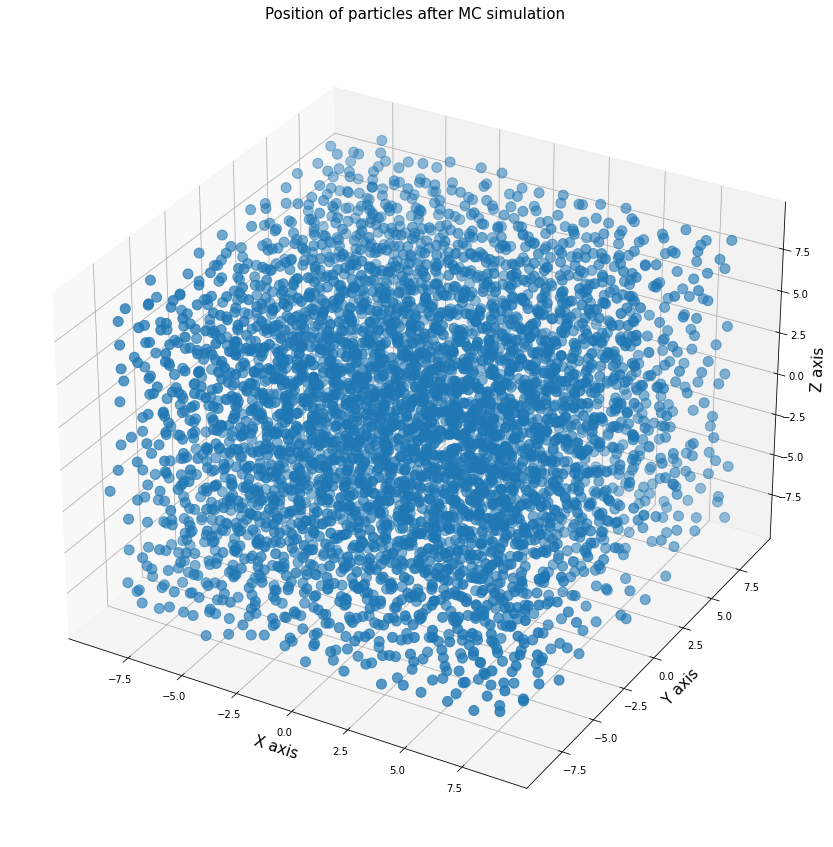

In [56]:
#plot the generated particle positions
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(q[-1,:,0],q[-1,:,1],q[-1,:,2], marker='o',s=100)
ax.set_xlabel('X axis', fontsize=15)
ax.set_ylabel('Y axis', fontsize=15)
ax.set_zlabel('Z axis', fontsize=15)
plt.title('Position of particles after MC simulation', fontsize=15)
plt.show()

__It takes approximately 1 million moves for system to equilibrate__